In [1]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
# Sample data (replace with your actual dataset)
# data = pd.DataFrame({
#     'title': ['Market Rally', 'Investing in Crypto', 'Stock Market Analysis', 'Economic Outlook'],
#     'text': [
#         'The stock market rallied today with major indices closing at record highs.',
#         'Investing in cryptocurrencies can be risky but potentially rewarding.',
#         'An analysis of the current stock market trends and future predictions.',
#         'The economic outlook for the next quarter looks promising.'
#     ],
#     'date': pd.to_datetime(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04'])
# })
data_temp = pd.read_csv('combined_file.csv')
data=data_temp[0:2000]
# Step 2: Preprocess data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data['title'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CPU times: user 5.06 s, sys: 280 ms, total: 5.34 s
Wall time: 5.43 s


<timed exec>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
# Step 3: Topic modeling using NMF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data['processed_text'])

nmf = NMF(n_components=5, random_state=42)
nmf.fit(X)

# Displaying topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
stock week discussed buy reddit split sentiment buying robinhood trading
Topic 1:
market close bear open crash th tuesday history monday cap
Topic 2:
musk elon twitter tesla deal say acquire accept sell sec
Topic 3:
year today ago red fall inflation trillion disney le result
Topic 4:
billion company share million say time amazon new earnings worth


/tmp/ipykernel_1203/2439785444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dominant_topic'] = nmf.transform(X).argmax(axis=1)


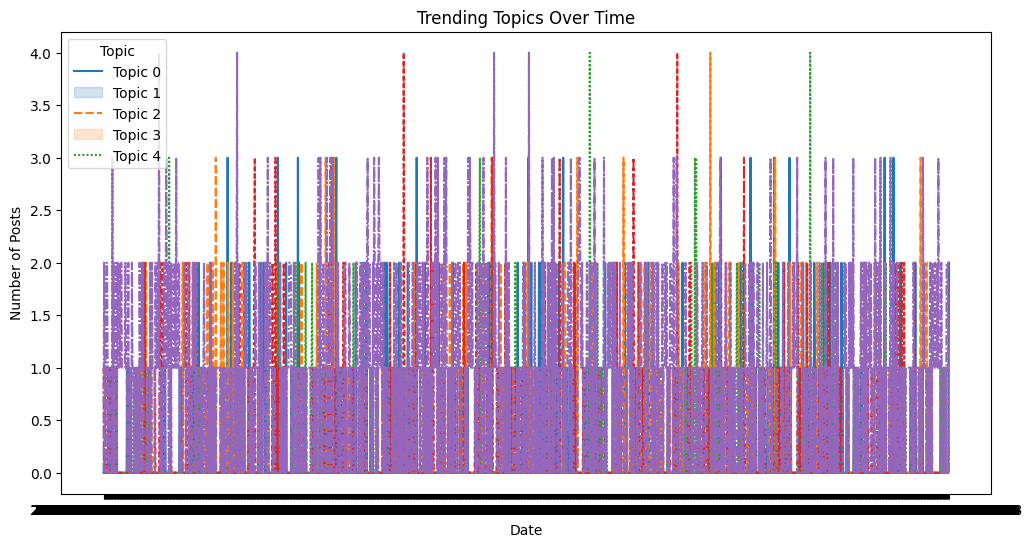

In [5]:
# Step 4: Trend detection
data['dominant_topic'] = nmf.transform(X).argmax(axis=1)

# Count the number of posts per topic per day
topic_counts = data.groupby(['created', 'dominant_topic']).size().unstack(fill_value=0)

# Step 5: Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=topic_counts)
plt.title('Trending Topics Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Topic', loc='upper left', labels=[f'Topic {i}' for i in range(5)])
plt.show()